## Расчёт позиций маркеров в системе координат полигона

На поле расположено 7 маркеров, координаты которых в СК полигона известны. Три маркера расположены в углах поля, по ним должна производиться "калибровка" камеры. Еще 4 маркера лежат в произвольных местах, но их координаты надо вычислить через найденную во время "калибровки" матрицу трансформации, после чего сравнить с реальными координатами. Задача в том, чтобы добиться минимальной погрешности в определении координат.

В файле `data.csv` содержится 7 столбцов со следующей структурой:

- **id**:int - id aruco-маркера в словаре ARUCO_DICT_5X5_250
- **rvec**:nparray - R-вектор координат маркера
- **tvec**:nparray - T-вектор координат маркера. Причем $T = \begin{bmatrix} x & y & z\end{bmatrix}$, где $x,y,z$ - это координаты маркера в СК камеры
- **R**:nparray - матрица поворота $R_{3x3} $ (точнее 9 её элементов)
- **roll** - 
- **pitch** - 
- **yaw** - 

In [126]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re, math


Начальные данные таковы:
![img](img1.png)

In [77]:
def mm(x, y):
    return y, 400 - x 

#aruco 72
m72_real_x, m72_real_y = mm(30, 30)
m72_real_z = 0

# aruco 74
m74_real_x, m74_real_y = mm(370, 30)
m74_real_z = 0

#aruco 71
m71_real_x, m71_real_y = mm(30, 570)
m71_real_z = 0

#aruco 73 dont used in this experiment
m73_real_x, m73_real_y = mm(370, 570)
m73_real_z = 0

#aruco 171
m171_real_x, m171_real_y = mm(100, 120)
m171_real_z = 0

#aruco 172
m172_real_x, m172_real_y = mm(270, 380)
m172_real_z = 0

#aruco 173
m173_real_x, m173_real_y = mm(220, 190)
m173_real_z = 0

#aruco 174
m174_real_x, m174_real_y = mm(100, 400)
m174_real_z = 0

In [108]:
class Marker():
    def __init__(self, marker_id, data, real_pos):
        """
        real_pos - tuple with real x, y, z coordinates
        """
        mydata = data[data['id']==marker_id]
        self.marker_id = marker_id
        self.rvecs = [list(map(lambda x: float(x), re.split("\s+", i.strip(" []")))) for i in mydata['rvec']]
        self.tvecs = [list(map(lambda x: float(x), re.split("\s+", i.strip(" []")))) for i in mydata['tvec']]
        self.Rs = [list(map(lambda x: float(x), re.split("\s+", i.strip(" []")))) for i in mydata['R']]
        self.rolls = [float(e) for e in mydata['roll']]
        self.pitches = [float(e) for e in mydata['pitch']]
        self.yaws = [float(e) for e in mydata['yaw']]
        
        #look at means with numpy
        self.rvec = np.mean(np.array(self.rvecs, dtype=np.float32), 0)
        self.tvec = np.mean(np.array(self.rvecs, dtype=np.float32), 0)
        self.R = np.mean(np.array(self.Rs, dtype=np.float32), 0).reshape(3, 3)
        self.R = np.dot(self.R, np.array([1, 0, 0, 0, -1, 0, 0, 0, -1]).reshape(3,3))
        self.roll = np.mean(np.array(self.rolls, dtype=np.float32), 0)
        self.pitch = np.mean(np.array(self.pitches, dtype=np.float32), 0)
        self.yaw = np.mean(np.array(self.yaws, dtype=np.float32), 0)
        
        self.tvec4 = np.concatenate([self.tvec, [1]])
        self.rvec4 = np.concatenate([self.rvec, [1]])
        
        self.real_position = np.array(real_pos)
        MAGIC_NUMBER = 10
        self.axis_z = self.tvec + (self.R.transpose()[2]*MAGIC_NUMBER)
        self.axis_z4 = np.concatenate([self.axis_z, [1]])
        
    def __str__(self):
        return "Marker id={}; tvec={};".format(self.marker_id, self.tvec)
        

In [94]:
data = pd.read_csv("data.csv", delimiter=";")

Определим каждый маркер, как отдельный объект, так будет проще читать

In [109]:
m71 = Marker(71, data, (m71_real_x, m71_real_y, m71_real_z, 1))
m72 = Marker(72, data, (m72_real_x, m72_real_y, m72_real_z, 1))
#m73 = Marker(73, data, (m73_real_x, m73_real_y, m73_real_z, 1))
m74 = Marker(74, data, (m74_real_x, m74_real_y, m74_real_z, 1))

m171 = Marker(171, data, (m171_real_x, m171_real_y, m171_real_z, 1))
m172 = Marker(172, data, (m172_real_x, m172_real_y, m172_real_z, 1))
m173 = Marker(173, data, (m173_real_x, m173_real_y, m173_real_z, 1))
m174 = Marker(174, data, (m174_real_x, m174_real_y, m174_real_z, 1))

In [81]:
half_size = 6/2 # [mm]
Rt = m173.R.transpose()

x72_axis = np.concatenate([(Rt[0] * half_size) + m72.tvec, [0]])
y72_axis = np.concatenate([(Rt[1] * half_size) + m72.tvec, [0]])
z72_axis = np.concatenate([(Rt[2] * 0) + m72.tvec, [0]])
t72_axis = np.concatenate([m72.tvec, [1]])

M = np.concatenate([x72_axis, y72_axis, z72_axis, t72_axis]).reshape(4,4)

t173_axis = np.concatenate([m172.tvec, [1]])
np.matmul(t173_axis, np.linalg.inv(M))

array([-0.0275262 , -0.03193714,  0.11077833,  1.        ])

In [76]:
half_size = 6/2 # [mm]
R = m72.R
tvec = m72.tvec

x72_axis = np.concatenate([R[0]*half_size + tvec, [0]])
y72_axis = np.concatenate([R[1]*half_size + tvec, [0]])
z72_axis = np.concatenate([R[2]*0 + tvec, [0]])
t72_axis = np.concatenate([tvec, [1]])

M = np.concatenate([x72_axis, y72_axis, z72_axis, t72_axis]).reshape(4,4)
print(M)

t_axis = np.concatenate([m74.tvec, [1]])
print(np.matmul(t_axis, np.linalg.inv(M)))
print(m74.real_position)

[[ 1.03681648  4.87848234 -0.40592548  0.        ]
 [ 3.64572644  2.51501656 -2.77367592  0.        ]
 [ 1.56038785  1.93882668 -0.69546354  0.        ]
 [ 1.56038785  1.93882668 -0.69546354  1.        ]]
[-0.00982803 -0.00623688  0.03080761  1.        ]
[370  30   0]


In [116]:
def get_pos(m):
    t = m.tvec
    R = m.R
    M = np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                  [R[1,0], R[1,1], R[1,2], t[1]],
                  [R[2,0], R[2,1], R[2,2], t[2]],
                  [0,      0,      0,      1]])
    M_i=np.linalg.inv(M)
    worldPos = [M_i[0,3],M_i[1,3],M_i[2,3]]
    return M, M_i, worldPos

worldPos = [0, 0, 0]
for i, m in enumerate([m72, m74, m71]):
    print(m)
    M, M_i, worldPos[i] = get_pos(m)
    print(M, "\n", M_i)
    print(worldPos, "\n\n\n\n\n")

Marker id=72; tvec=[ 1.5603878   1.9388267  -0.69546354];
[[-0.1745238  -0.97988522 -0.09651268  1.56038785]
 [ 0.69511282 -0.19206324  0.69273752  1.93882668]
 [-0.6973471   0.05380565  0.71466112 -0.69546354]
 [ 0.          0.          0.          1.        ]] 
 [[-0.17454797  0.69515125 -0.69739829 -1.56043034]
 [-0.97993081 -0.19204432  0.0538165   1.93884019]
 [-0.09654184  0.69276859  0.71471034 -0.69546053]
 [ 0.          0.          0.          1.        ]]
[[-1.5604303418211116, 1.938840188326717, -0.6954605338056477], 0, 0] 





Marker id=74; tvec=[ 1.5755318   1.9349256  -0.69560057];
[[-0.16680336 -0.98195654 -0.08871286  1.57553184]
 [ 0.70071077 -0.18138193  0.68996996  1.93492556]
 [-0.69362938  0.05292328  0.71832687 -0.69560057]
 [ 0.          0.          0.          1.        ]] 
 [[-0.16682353  0.7007403  -0.69368023 -1.5755689 ]
 [-0.98202023 -0.18137117  0.0529325   1.93496373]
 [-0.08873672  0.69001014  0.71839391 -0.69559551]
 [ 0.          0.          0.       

![img](img1.png)

A:
 [[ 0.59526102  1.56038785  1.56280148]
 [ 8.86620188  1.93882668  1.96100175]
 [ 6.45114768 -0.69546354 -0.71758163]] 

B:
 [[  0  30 570]
 [  0 370 370]
 [ 10   0   0]]

Op: Cam -> Polygon =
 [[-2.15341249e+04  1.20959502e+04 -1.46371957e+04]
 [ 2.68252446e+02 -2.27289153e+01  6.48550126e+00]
 [-5.87028368e-01  7.01885523e-01  6.39634461e-01]]

calculated =  [-7.13616975e+04  4.08100334e+02 -1.73997049e+00] 
real =  [120 300   0   1]


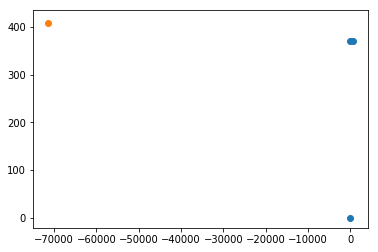

0.467800065589788 -1997999.9999999988
842.2213339496451


In [122]:
A = np.concatenate([ m72.axis_z, m72.tvec, m71.tvec]).reshape(3, 3).transpose()
MN = 10
B = np.array([0,  m72_real_x, m71_real_x, \
              0,  m72_real_y, m71_real_y, \
              10, m72_real_z, m71_real_z]).reshape(3, 3)
print("A:\n",A,"\n\nB:\n", B)

Op = np.dot(B, np.linalg.inv(A))
print("\nOp: Cam -> Polygon =\n", Op)

np.dot(Op, m71.tvec)

K = m171.tvec

Kop = np.dot(Op, K)
print("\ncalculated = ", Kop, "\nreal = ", m171.real_position)
plt.scatter(B[0],B[1])
plt.scatter(Kop[0],Kop[1])
plt.show()
detA = np.linalg.det(A)
detB = np.linalg.det(B)
print(detA, detB)
print(np.linalg.cond(A))

In [118]:
print([m173_real_x, m173_real_y, m173_real_z])
print(np.dot(Op, m173.tvec))

[190, 180, 0]
[-2.69975367e+02  3.73851104e+02  2.44956710e-02]


In [119]:
from scipy.spatial.transform import Rotation as R

In [120]:
r = R.from_rotvec(m72.rvec)
print(r.as_euler('zyx', degrees=True))

P72 = np.concatenate([m72.tvec, [1]])
P71 = np.concatenate([m71.tvec, [1]])
P74 = np.concatenate([m74.tvec, [1]])

print(P72)
print(P71)
print(P74)
P72loc = np.dot(P72, np.linalg.inv(M))
P71loc = np.dot(P71, np.linalg.inv(M))
P74loc = np.dot(P74, np.linalg.inv(M))
print("\n\n")
print(P72loc)
print(P71loc)
print(P74loc)

[-100.09936715    5.53969853  135.89258646]
[ 1.56038785  1.93882668 -0.69546354  1.        ]
[ 1.56280148  1.96100175 -0.71758163  1.        ]
[ 1.57553184  1.93492556 -0.69560057  1.        ]



[-2.1456132   0.24028721 -1.42047203  2.86265921]
[-2.16610747  0.22248599 -1.43628546  2.91824847]
[-2.14470779  0.25151775 -1.43132051  2.83143646]


In [115]:
-3.68792243e+01

-36.8792243

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


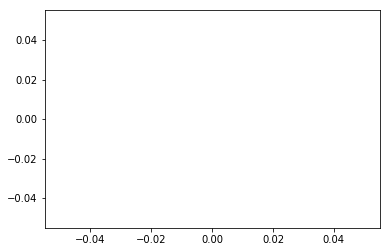

In [127]:

coords=np.concatenate([m74.tvec, m72.tvec, m71.tvec]).reshape(3,-1).transpose()
x = coords[0]
y = coords[1]
z = coords[2]

plt.scatter(x, y, z)
plt.show()


In [ ]:
[-0.17185973,
  0.98206893,
  0.07749094,
  0.70365828,
  0.17742803,
  -0.6880293,
  -0.68944127,
  -0.06371739,
  -0.72153367]